# Final Project Name Entity Recognition & WordCloud
by Latifa Tan </br>
This file aims on conduct big data NER and WordCloud to discover the popular word used and hot topics in reviews for games on Steam platform. In this Notebook, we load steam game statistics and game reviews files. After data preparation, we split data into specific categories for comparison. We first splited data based on the number of concurrent users they have( low, medium-low, medium-high, high, very high) as we got from our previous classification analysis. Beyond concurrent users, we also splited data into free game VS paid game. From these comparison, we can get a gliance on how users talk about games in difference types and classed. To get more insights about users' likes and hates for games, we also conducted NER based on data split of Positive VS Negative reviews. From the results, we can see what words people used when they praise and thumbs-down a game.

The results are expected to offer insights on 
1) what expects does user cares about of a game; 
2) how does user define 'good' game and 'bad' game;
3) if a game publisher want high-concurrent-user for their game, what they should focus on game production and marketing.

In [1]:
# Mute process update log
import warnings
warnings.filterwarnings('ignore')
# Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace, expr, avg
from pyspark.sql.types import BooleanType, IntegerType, FloatType, TimestampType
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Create SparkSession
spark = SparkSession.builder \
    .appName("NER and WordCloud") \
    .master("local[4]") \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.memory", "12g") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .getOrCreate()

# Load data from GCP CSV file
file_path = "gs://msca-bdp-student-gcs/Group5/english_reviews/part-00000-dbebe656-10b1-42c2-93d1-bf55b07e437d-c000.csv"
df_review = spark.read.csv(file_path, header=True, inferSchema=True)
df_review = df_review.select('appid','review','voted_up')

In [43]:
parquet_file_path_free = "gs://msca-bdp-student-gcs/Group5/Steam_data/df_f_cc.parquet/part-00000-781be952-4d1b-4257-89ae-a616355d8664-c000.snappy.parquet"
df_free_id = spark.read.parquet(parquet_file_path_free)
parquet_file_path_paid = "gs://msca-bdp-student-gcs/Group5/Steam_data/df_p_cc.parquet/part-00000-01aa344c-1bc4-4b27-a481-7216cb08a1f6-c000.snappy.parquet"
df_paid_id = spark.read.parquet(parquet_file_path_paid)

In [3]:
df_paid_id.select('ccu_category').distinct().show()

+------------+
|ccu_category|
+------------+
|         low|
|  medium_low|
|   Very high|
|        high|
| medium_high|
+------------+



# Filter thumbs up

In [5]:
df_negative = df_review.where(df_review.voted_up == '0')
df_positive = df_review.where(df_review.voted_up == '1')

# Join First

In [3]:
# paidClass-review
df_joined_po = df_review.join(df_positive, on='appid', how='inner')

# Filter Target Class

In [78]:
df_joined_low = df_joined_paid.where(df_joined_paid.ccu_category == 'low')
df_joined_medium_low = df_joined_paid.where(df_joined_paid.ccu_category == 'medium_low')
df_joined_medium_high = df_joined_paid.where(df_joined_paid.ccu_category == 'medium_high')
df_joined_high = df_joined_paid.where(df_joined_paid.ccu_category == 'high')
df_joined_very_high = df_joined_paid.where(df_joined_paid.ccu_category == 'Very high')

# Sampling

In [6]:
df_positive_sampled_data = df_positive.select("*").filter(col("review").isNotNull()).sample(fraction=0.01, seed=42).limit(1000000)

# NER

In [3]:
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import SentenceDetector, Tokenizer, NerDLModel, NerConverter
from pyspark.ml import Pipeline
from sparknlp.annotator import WordEmbeddingsModel

In [7]:
document_assembler = DocumentAssembler() \
    .setInputCol("review") \
    .setOutputCol("document")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentences")

tokenizer = Tokenizer() \
    .setInputCols(["sentences"]) \
    .setOutputCol("tokens")

# Add word embeddings model
word_embeddings = WordEmbeddingsModel.pretrained("glove_100d", "en") \
    .setInputCols(["document", "tokens"]) \
    .setOutputCol("embeddings")

# Update NerDLModel to use embeddings
ner_dl_model = NerDLModel.pretrained("ner_dl", "en") \
    .setInputCols(["document", "tokens", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverter() \
    .setInputCols(["document", "tokens", "ner"]) \
    .setOutputCol("entities")

pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    word_embeddings,
    ner_dl_model,
    ner_converter
])

# Fit and transform the data
model = pipeline.fit(df_positive_sampled_data)
result = model.transform(df_positive_sampled_data)

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]


In [8]:
result_df = result.selectExpr("explode(entities.result) as entity").groupBy("entity").count().orderBy("count", ascending=False)
#result_df.show()

# WordCloud

In [7]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [12]:
!pip install --upgrade regex
!pip install --upgrade nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.1/785.1 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.1 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.6.4
    Uninstalling nltk-3.6.4:
      Successfully uninstalled nltk-3.6.4


In [11]:
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
nltk.download("stopwords")

from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


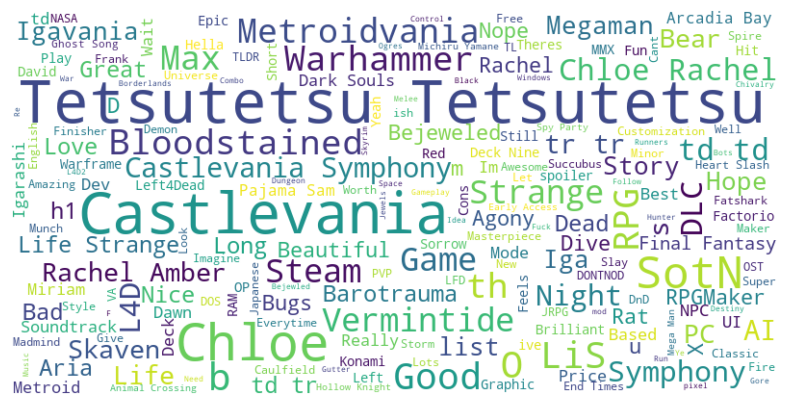

In [12]:
# Small sample: paid-low-1000
stop_words = set(stopwords.words("english"))

entities_df = result.select("entities.result").toPandas()

all_entities = [entity for entities in entities_df["result"] for entity in entities]
filtered_entities = [entity for entity in all_entities if entity.lower() not in stop_words]

# Combine all entities into a single string
text = " ".join(filtered_entities)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [9]:
def wordCloud(result):
    stop_words = set(stopwords.words("english"))

    entities_df = result.select("entities.result").toPandas()

    all_entities = [entity for entities in entities_df["result"] for entity in entities]
    filtered_entities = [entity.lower() for entity in all_entities if entity.lower() not in stop_words]

    # Combine all entities into a single string
    text = " ".join(filtered_entities)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white",collocations=False).generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

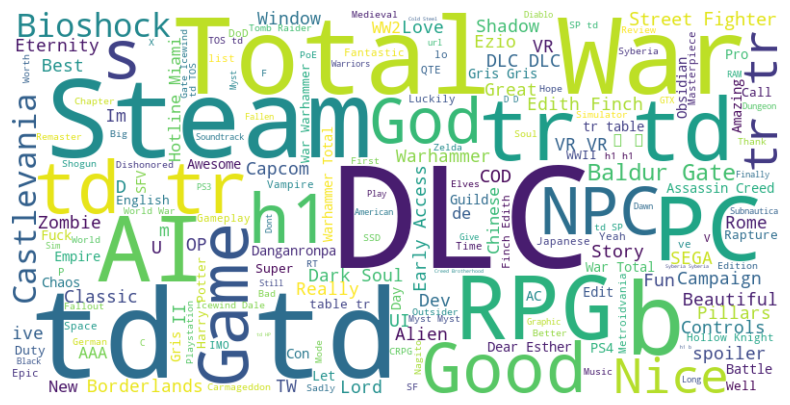

In [21]:
# paid-small
wordCloud(result)

24/11/28 02:00:09 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1732731406645_0012_01_000060 on host: hub-hub-msca-bdp-dphub-student-latifatan2024-w-1.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2024-11-28 02:00:09.456]Container killed on request. Exit code is 137
[2024-11-28 02:00:09.457]Container exited with a non-zero exit code 137. 
[2024-11-28 02:00:09.458]Killed by external signal
.
24/11/28 02:00:09 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 60 for reason Container from a bad node: container_1732731406645_0012_01_000060 on host: hub-hub-msca-bdp-dphub-student-latifatan2024-w-1.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2024-11-28 02:00:09.456]Container killed on request. Exit code is 137
[2024-11-28 02:00:09.457]Container exited with a non-zero exit code 137. 
[2024-11-28 02:00:09.458]Killed by external signal
.
24/11/28 0

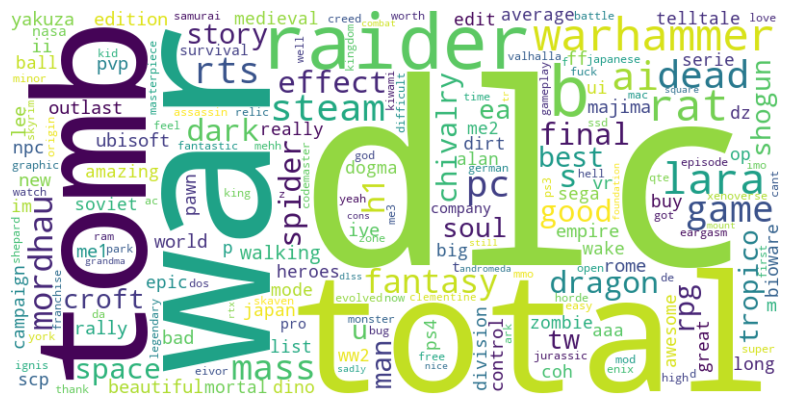

In [92]:
# paid medium_low
wordCloud(result)

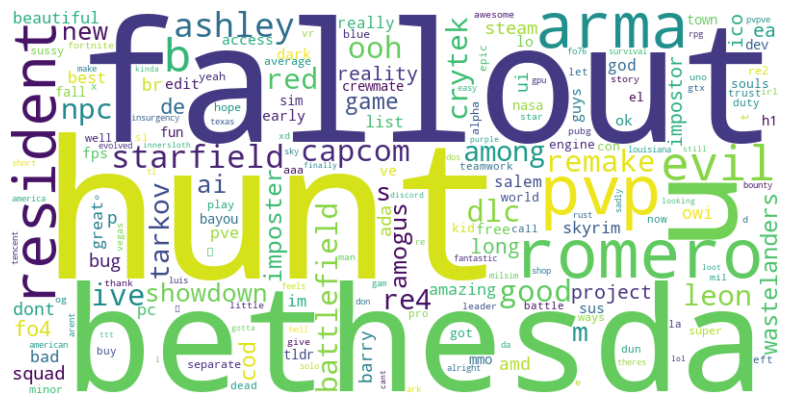

In [87]:
# paid medium_high
wordCloud(result)

24/11/28 01:46:44 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1732731406645_0012_01_000055 on host: hub-hub-msca-bdp-dphub-student-latifatan2024-w-1.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2024-11-28 01:46:44.344]Container killed on request. Exit code is 137
[2024-11-28 01:46:44.345]Container exited with a non-zero exit code 137. 
[2024-11-28 01:46:44.345]Killed by external signal
.
24/11/28 01:46:44 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 55 for reason Container from a bad node: container_1732731406645_0012_01_000055 on host: hub-hub-msca-bdp-dphub-student-latifatan2024-w-1.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2024-11-28 01:46:44.344]Container killed on request. Exit code is 137
[2024-11-28 01:46:44.345]Container exited with a non-zero exit code 137. 
[2024-11-28 01:46:44.345]Killed by external signal
.
24/11/28 0

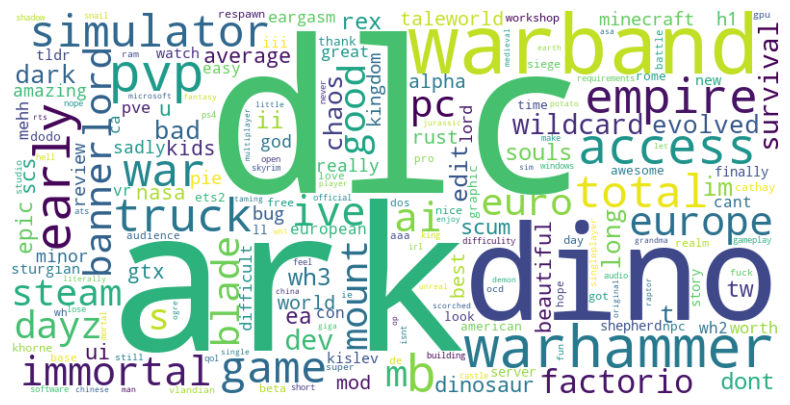

In [84]:
# paid high
wordCloud(result)

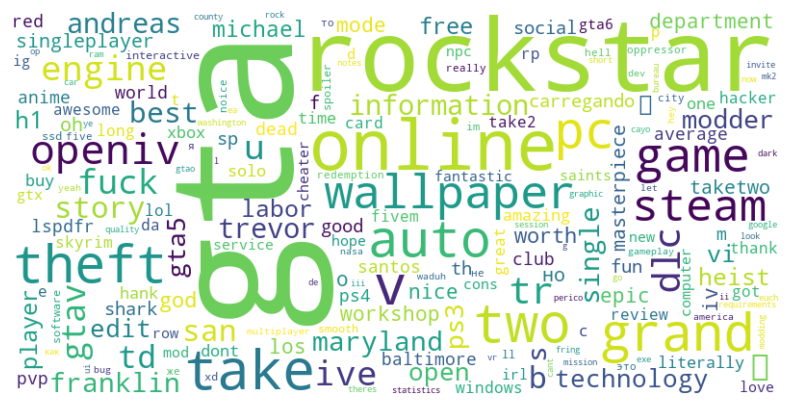

In [81]:
# paid very high
wordCloud(result)

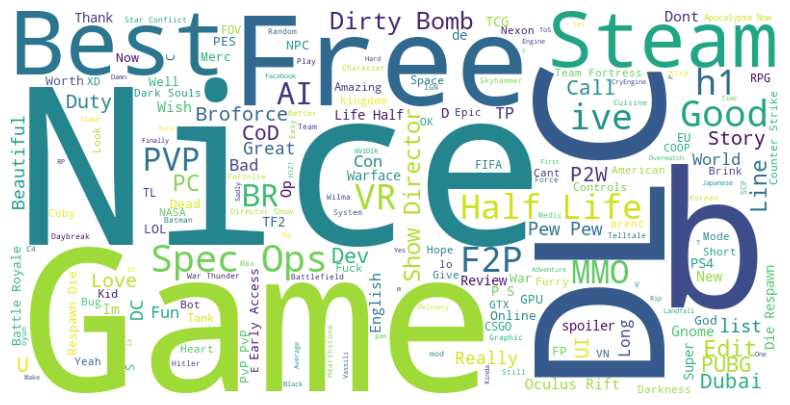

In [12]:
# free-low
wordCloud(result)

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


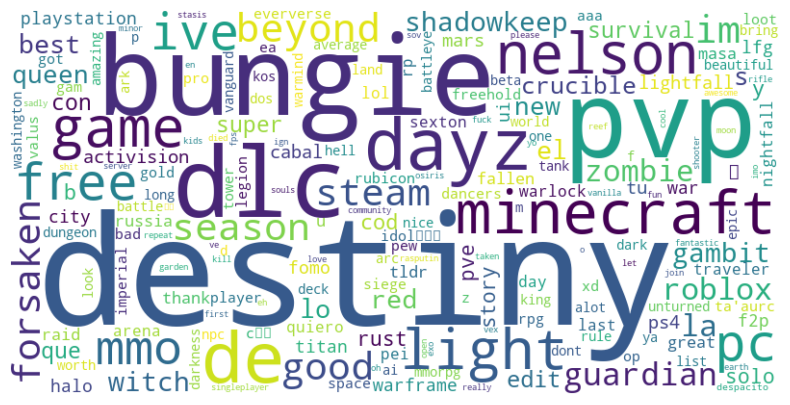

In [66]:
# free-med-low
wordCloud(result)

24/11/28 01:12:31 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1732731406645_0012_01_000044 on host: hub-hub-msca-bdp-dphub-student-latifatan2024-w-1.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2024-11-28 01:12:30.937]Container killed on request. Exit code is 137
[2024-11-28 01:12:30.945]Container exited with a non-zero exit code 137. 
[2024-11-28 01:12:30.946]Killed by external signal
.
24/11/28 01:12:31 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 44 for reason Container from a bad node: container_1732731406645_0012_01_000044 on host: hub-hub-msca-bdp-dphub-student-latifatan2024-w-1.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2024-11-28 01:12:30.937]Container killed on request. Exit code is 137
[2024-11-28 01:12:30.945]Container exited with a non-zero exit code 137. 
[2024-11-28 01:12:30.946]Killed by external signal
.
24/11/28 0

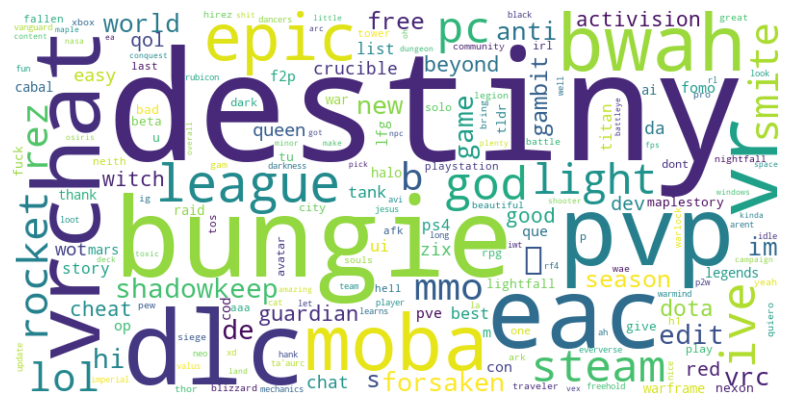

In [70]:
# free-med-high
wordCloud(result)

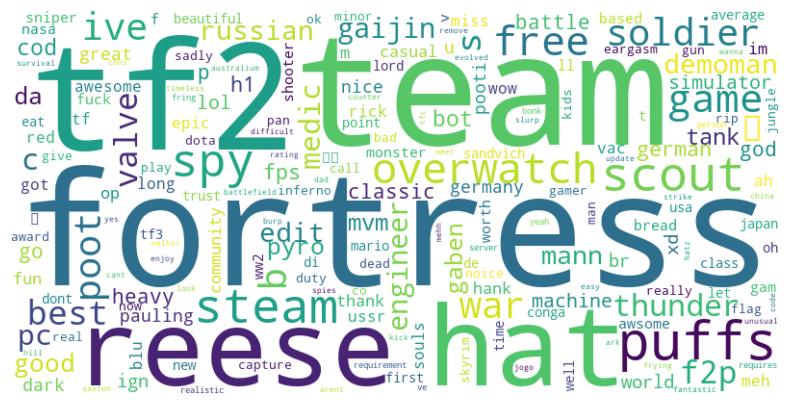

In [73]:
# free-high
wordCloud(result)

24/11/28 01:23:55 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1732731406645_0012_01_000049 on host: hub-hub-msca-bdp-dphub-student-latifatan2024-w-0.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2024-11-28 01:23:55.457]Container killed on request. Exit code is 137
[2024-11-28 01:23:55.458]Container exited with a non-zero exit code 137. 
[2024-11-28 01:23:55.458]Killed by external signal
.
24/11/28 01:23:55 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 49 for reason Container from a bad node: container_1732731406645_0012_01_000049 on host: hub-hub-msca-bdp-dphub-student-latifatan2024-w-0.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2024-11-28 01:23:55.457]Container killed on request. Exit code is 137
[2024-11-28 01:23:55.458]Container exited with a non-zero exit code 137. 
[2024-11-28 01:23:55.458]Killed by external signal
.
24/11/28 0

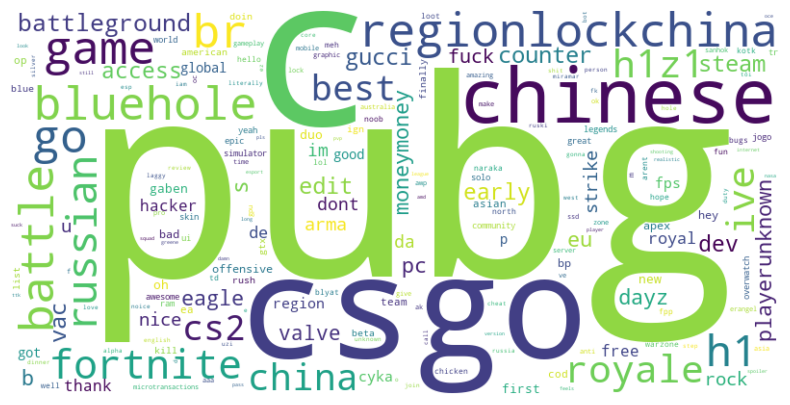

In [76]:
# free-very-high
wordCloud(result)

# Positive VS Negative

24/11/28 04:01:40 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1732731406645_0014_01_000002 on host: hub-hub-msca-bdp-dphub-student-latifatan2024-w-1.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2024-11-28 04:01:39.753]Container killed on request. Exit code is 137
[2024-11-28 04:01:39.753]Container exited with a non-zero exit code 137. 
[2024-11-28 04:01:39.754]Killed by external signal
.
24/11/28 04:01:40 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 2 for reason Container from a bad node: container_1732731406645_0014_01_000002 on host: hub-hub-msca-bdp-dphub-student-latifatan2024-w-1.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2024-11-28 04:01:39.753]Container killed on request. Exit code is 137
[2024-11-28 04:01:39.753]Container exited with a non-zero exit code 137. 
[2024-11-28 04:01:39.754]Killed by external signal
.
24/11/28 04

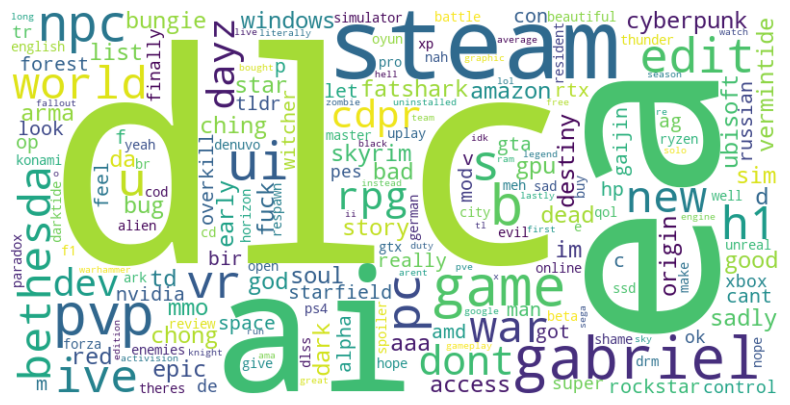

In [8]:
# negative
wordCloud(result)

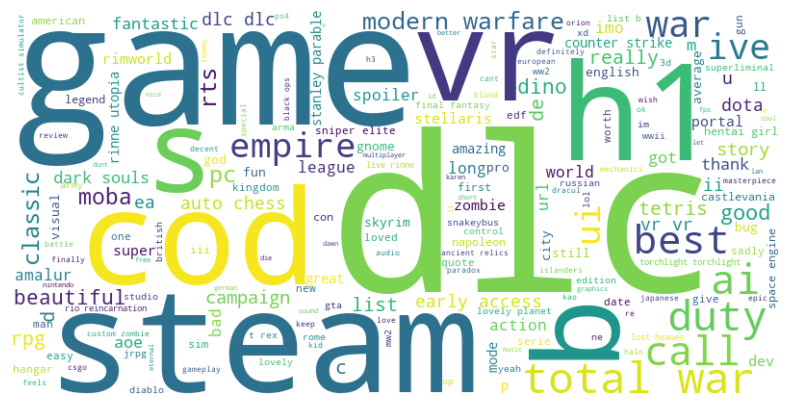

In [41]:
# positive diff seed 3
wordCloud(result)

24/12/01 20:40:20 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1733082257498_0003_01_000007 on host: hub-hub-msca-bdp-dphub-student-latifatan2024-w-1.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2024-12-01 20:40:20.167]Container killed on request. Exit code is 137
[2024-12-01 20:40:20.173]Container exited with a non-zero exit code 137. 
[2024-12-01 20:40:20.173]Killed by external signal
.
24/12/01 20:40:20 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 6 for reason Container from a bad node: container_1733082257498_0003_01_000007 on host: hub-hub-msca-bdp-dphub-student-latifatan2024-w-1.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2024-12-01 20:40:20.167]Container killed on request. Exit code is 137
[2024-12-01 20:40:20.173]Container exited with a non-zero exit code 137. 
[2024-12-01 20:40:20.173]Killed by external signal
.
24/12/01 20

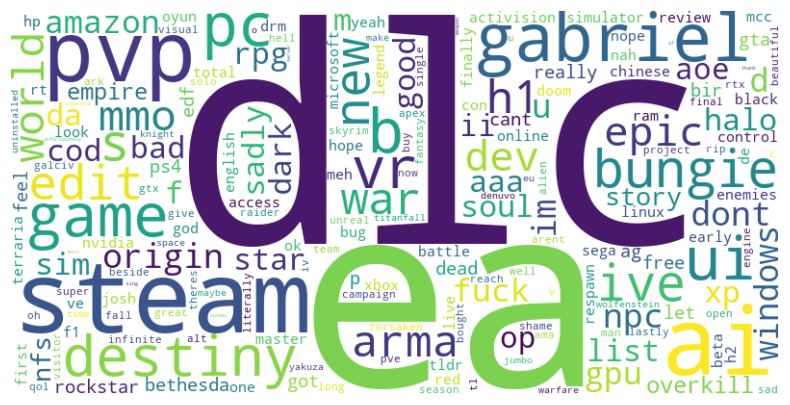

In [12]:
# negative diff
wordCloud(result)

In [13]:
df_negative.select('*').count()

6643014

In [14]:
df_positive.select('*').count()

43147968

In [15]:
df_review.select('*').count()

51544179